Links:
- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://surpriselib.com/


Inspiration:
- https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb


State of the art:
- https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k


In [60]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
import IPython
import sys

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from collections import defaultdict


In [82]:
"""
Load dataset
"""
# Load the dataset (download it if needed)
#data = Dataset.load_builtin('ml-100k')
data = pd.read_csv('ml-100k/u.data', sep='\t', encoding='latin-1', usecols=[0,1,2,3], names=['user_id', 'item_id', 'rating', 'timestamp'], header=None)

# Convert to pandas dataframe
#df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
df = pd.DataFrame(data, columns=['user_id','item_id','rating', 'timestamp'])

#print data from first 10 rows
display(df.head())
print(df.shape)

#user data
user_data = pd.read_csv('ml-100k/u.user', sep="|", encoding='latin-1', header=None)
user_data.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']

display(user_data.head(10))

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


(100000, 4)


,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


Number of ratings:
 4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64


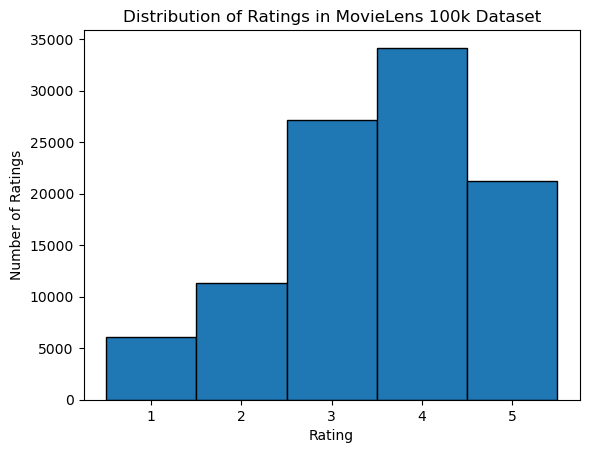

,item_id,rating
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485
285,286,481
287,288,478
0,1,452
299,300,431
120,121,429


,user_id,rating
404,405,737
654,655,685
12,13,636
449,450,540
275,276,518
415,416,493
536,537,490
302,303,484
233,234,480
392,393,448


In [63]:
"""
Exploratory Data Analysis (EDA) 
"""
rating_counts = df['rating'].value_counts()
print("Number of ratings:\n", rating_counts) 

plt.hist(df['rating'], bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align="left")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings in MovieLens 100k Dataset")
plt.show()


#ratings per movie
n_movie_ratings = df.groupby('item_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
display(n_movie_ratings.head(10))


#ratings per user 
n_user_ratings = df.groupby('user_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
display(n_user_ratings.head(10))


In [64]:
"""
Define format
"""
#create an reader -> iterate through data
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader=reader)


In [66]:
"""
Comparing RMSE for different algorithms using cross-validation
"""
benchmark = []

#iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    #perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)

    #get results and append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

#printing results 
results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
display(results)

C:\Users\emilh\AppData\Local\Temp\ipykernel_12036\826808361.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\emilh\AppData\Local\Temp\ipykernel_12036\826808361.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\emilh\AppData\Local\Temp\ipykernel_12036\826808361.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\emilh\AppData\Local\Temp\ipykernel_12036\826808361.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.936926,0.889799,0.115801
NMF,0.960631,1.445827,0.099417
KNNBasic,0.978515,0.413098,2.641515
NormalPredictor,1.527416,0.117388,0.167874


In [69]:
"""
Training and testing 
"""
#create trainset and testset
trainset, testset = train_test_split(data, test_size=.25)

#defines algorithms (probably try to tune parameters later , otherwise mention it in the report)
algo1 = SVD() #SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value) -> look at parameters
algo2 = NMF()
algo3 = NormalPredictor()
algo4 = KNNBasic()

#train and test algorithms
svd_predictions = algo1.fit(trainset).test(testset)
nmf_predictions = algo2.fit(trainset).test(testset)
normal_predictions = algo3.fit(trainset).test(testset)
knn_predictions = algo4.fit(trainset).test(testset)

#print answers
accuracy.rmse(svd_predictions)
accuracy.rmse(nmf_predictions)
accuracy.rmse(normal_predictions)
accuracy.rmse(knn_predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9341
RMSE: 0.9636
RMSE: 1.5318
RMSE: 0.9732


0.9731977669920835

In [70]:
"""
Training the model on dataset but using new movies 
"""
trainset = data.build_full_trainset()
new_algo = SVD()
new_algo.fit(trainset)

#predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset() #antitest is used to use movies not present in the testset when testing

#predicting the ratings 
predictions = new_algo.test(testset)

#look at format
print(predictions[2])
accuracy.rmse(predictions)


Prediction(uid=196, iid=51, r_ui=3.52986, est=3.5257915018113035, details={'was_impossible': False})

In [83]:
"""
Prediction functions 
"""
def get_all_predictions(predictions):
    
    #first map the predictions to each user.
    top_n = defaultdict(list)       #defaultdict is a dictionary that has a default value for keys that have not been set yet
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n


def get_predictions(user_id):
    return tmp_transpose.iloc[user_id]


"""
Get top recommended movies for an user
"""
all_predictions = get_all_predictions(predictions)      #get recommendations for all users
n = 4                                                   #number of movies to recommend


#sort the predictions for each user and retrieve the n highest ones
for uid, user_ratings in all_predictions.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_predictions[uid] = user_ratings[:n]

#convert to dataframe
tmp = pd.DataFrame.from_dict(all_predictions)
tmp_transpose = tmp.transpose()

#get recommendations for user 30 (format: movie_id, predicted rating)
user_id = 67

results = get_predictions(user_id)
print(results)

0    (318, 4.204633121577367)
1    (215, 4.143201808562273)
2    (315, 4.121553897139253)
3    (427, 4.097873235945787)
Name: 254, dtype: object


In [95]:
"""
Retrieve recommended movie details i.e title and genre from the ids
"""
#retrieve movie titles and genres
movie_data = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
movie_data.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 
                    'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


#retrieve movie ids 
recommended_movies_ids = []

for x in range (0, n):
    recommended_movies_ids.append(results[x][0])


#retrieve recommended movie + details
recommended_movies = movie_data[movie_data['movie_id'].isin(recommended_movies_ids)]
display(recommended_movies)


#NB: remove genres with value 0 (i.e. not present in the movie) or find a way to print entire row instead of truncation  

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
214,215,Field of Dreams (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Field%20of%20Dreams%20(1989),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314,315,Apt Pupil (1998),23-Oct-1998,NaN,http://us.imdb.com/Title?Apt+Pupil+(1998),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%20List%20(1993),0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
426,427,To Kill a Mockingbird (1962),01-Jan-1962,NaN,http://us.imdb.com/M/title-exact?To%20Kill%20a%20Mockingbird%20(1962),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
"""
Look at user data to see if recommended movies are in line with user preferences
"""
#looking at previous ratings of specific user
user_details = df[df['user_id'] == user_id].sort_values('rating', ascending=False)
display(user_details)
print(user_details.shape)       #number of ratings for user

#looking at the previous movies details rated by the user
history_movie_ids = user_details['item_id']
history_movie_ids = history_movie_ids.iloc[:n]     #get only the top n movies rated by the user
history_movies = movie_data[movie_data['movie_id'].isin(history_movie_ids)]

#display(history_movies)        #display all movies rated by the user
display(history_movies)     #display only top movies rated by the user 


,user_id,item_id,rating,timestamp
2131,67,64,5,875379211
11891,67,7,5,875379794
93281,67,117,5,875379794
4095,67,240,5,875379566
4492,67,405,5,875379794
8389,67,1093,5,875379419
28653,67,24,4,875379729
26396,67,25,4,875379420
14875,67,123,4,875379322
14771,67,833,4,875379794


(30, 4)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
63,64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Shawshank%20Redemption,%20The%20(1994)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%20(1996)",0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
239,240,Beavis and Butt-head Do America (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Beavis%20and%20Butt-head%20Do%20America%20(1996),0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Algorithms:
- NormalPredictor (Just random)
- BaselineOnly (Predicts the baseline estimate for a given user)
- KNNBasic
- SVD 
- NMF
- Kaggle (state of the art?)


#### Look at parameters values
Default values for SVD:
- n_factors - 100
- n_epochs - 20
- lr_all – 0.005
- reg_all – 0.02